<a href="https://colab.research.google.com/github/aryatomarAI/Advanced-python-modules/blob/main/Deep-Learning-plus-Project/Dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐕‍🦺 Using Tensorflow 2.0 and Transfer learning to classify different dog breeds
This notebook builds an end-to-end multi-class image classifier using Tensorflow and Tensorflow Hub

We're using Kaggle Dog Identification competition
## 1. Problem
   Identifying the breed of a dog given an image of a dog.
## 2. Data
   The data we're using is from [Kaggle's dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/data)
## 3. Evaluation
   The evaluation is a file with prediction probabilities for each dog breed of each test image.

   [Evaluated on Multi Class Log Loss between the predicted probability and the observed target](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation)

## 4. Features

Some Information about the data:

We're dealing with images (Unstructured data).
It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub.




## Get our Workspace ready

In [3]:
# Import Tensorflow into colab
import tensorflow as tf
print("We are using Tensor flow version",tf.__version__)

We are using Tensor flow version 2.4.1


In [4]:
# Importing Tensflow_hub and checking for GPU 
import tensorflow_hub as hub
print("Tensorflow hub version:",hub.__version__)

print("GPU","available" if tf.config.list_physical_devices("GPU") else "not available")

Tensorflow hub version: 0.12.0
GPU available


## Loading our data lables
**Getting our data ready(turning into tensors)**

With all machine learning models our data has to be in numerical format, So we have turn our images into tensors(numerical representations)


In [5]:
# Let's check our labels first
import pandas as pd

im_labels=pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
im_labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,6503f802e8faf7823db3f36554bc107e,scottish_deerhound
freq,1,126


In [8]:
im_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


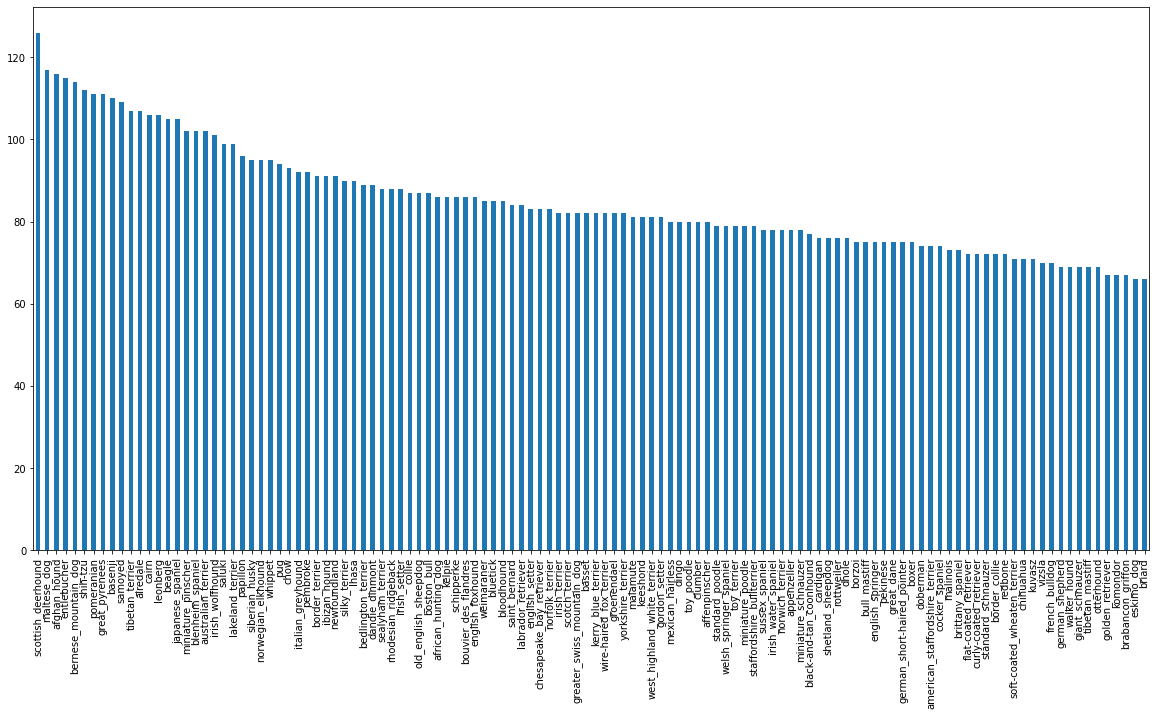

In [9]:
# How many images are there of each breed
im_labels["breed"].value_counts().plot(kind='bar',figsize=(20,10))

## Preparing the Images 

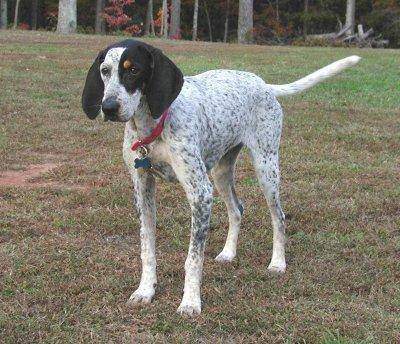

In [10]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`im_labels`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [11]:
# Create pathnames from image ids
filename=['drive/MyDrive/Dog Vision/train/' + fname + ".jpg" for fname in im_labels["id"]]

filename[:20]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'drive/MyDrive/Dog Vision/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'drive/MyDrive/Dog Vision/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'drive/MyDrive/Dog Vision/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'drive/MyDrive/Dog Vision/train/006cc3ddb9dc1bd827479569fcdc52d

In [12]:
# check whether number of filenames matches number of actual image files in train folder 
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/"))==len(filename):
  print("Filename match actual amount of files!!!")
else:
  print("Oops your filename doesn't match actual amount of files")

Filename match actual amount of files!!!


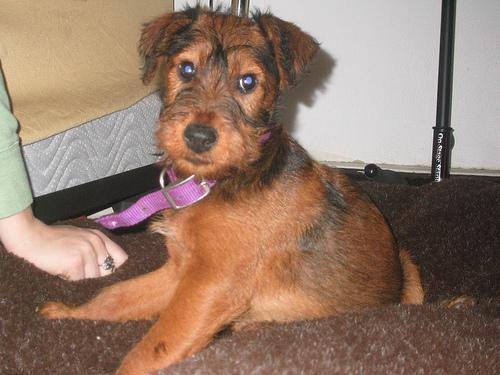

In [13]:
Image(filename[120])


In [14]:
im_labels["breed"][120] # breed of above the dog in above image

'irish_terrier'

In [15]:
# turn labels into numpy array
import numpy as np
dog_labels=im_labels['breed'].to_numpy()
dog_labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [16]:
# check if dog_labels have same amount of items as filename
if len(dog_labels)==len(filename):
  print("length Match")
else:
  print("Length Doesn't match, please check your data directory")

length Match


Since machine learning models can't take strings as input we've to convert our string array into numbers

To begin with, we'll find all the unique dog breed names inside the dog_labels array

Then we'll go through the list of label's and compare them to unique breed and create a list of booleans indicating 
which one is the real label(`True`) and which one is the false label (`False`)


In [17]:
#  find the unique labels values
unique_breeds=np.unique(dog_labels)
len(unique_breeds) 

120

In [18]:
# So as we know we have 120 dog breeds into our data 
# Now turn a single label into an array of booleans
print(dog_labels[0])
dog_labels[0]==unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [19]:
# now turn every dog_label into boolean array
boolean_labels=[label==unique_breeds for label in dog_labels]
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [20]:
len(boolean_labels)

10222

In [21]:
# Turning our boolean array into integers, how?
# let's see an example
print(dog_labels[0])   # Our dog breed
print(np.where(unique_breeds==dog_labels[0]))  #index where label occurs
print(boolean_labels[0].argmax())              #index where label occurs in boolean array
print(boolean_labels[0].astype(int))           # there will be a 1 where the our dog label occurs 


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [22]:
# Now that we have to split our data into training data set and validation data set


### Splitting our data 
Creating our own data validation 

In [23]:
# set up X and y
X=filename
y=boolean_labels

X[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [24]:
y[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

We're going to startoff experimenting with ~ 1000 images and then increase if needed

In [25]:
# Set number of images to use in experimenting 
NUM_IMAGES=2000 #@param{type:"slider",min:"1000",max:"10000",step:"1000"}


In [26]:
# let's split our data into training and validation data sets
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

len(X_train),len(y_train),len(X_val),len(y_val)

(1600, 1600, 400, 400)

### Preprocess Images (Turning Images into tensors)
To preprocess our images into Tensors we're going to write a function which will do the following things:
1. Take an image file path as input
2. Use tensorflow to read the image and save it to the varaiable, `image`
3. Turn our image ( a jpg into tensors)
4. Resize our image to be a shape of 250,250
5. Return the modified image

In [27]:
# Convert image to numpy array
from matplotlib.pyplot import imread
image=imread(filename[35])
image.shape

(1200, 1600, 3)

In above tuple 3 is color channel RGB ( Red, Blue and Green)

In [28]:
image

array([[[137, 123, 114],
        [137, 123, 114],
        [136, 122, 113],
        ...,
        [119, 105,  92],
        [120, 106,  93],
        [119, 105,  92]],

       [[132, 118, 109],
        [134, 120, 111],
        [136, 122, 113],
        ...,
        [114, 100,  87],
        [115, 101,  88],
        [115, 101,  88]],

       [[130, 116, 107],
        [134, 120, 111],
        [139, 125, 116],
        ...,
        [107,  95,  81],
        [108,  96,  82],
        [110,  98,  84]],

       ...,

       [[162, 154, 152],
        [159, 151, 149],
        [154, 146, 144],
        ...,
        [ 99,  78,  73],
        [101,  80,  75],
        [103,  82,  77]],

       [[160, 152, 150],
        [156, 148, 146],
        [150, 142, 140],
        ...,
        [ 99,  75,  71],
        [100,  76,  72],
        [101,  76,  72]],

       [[161, 153, 151],
        [156, 148, 146],
        [149, 141, 139],
        ...,
        [106,  81,  77],
        [107,  82,  78],
        [105,  80,  76]]

In [29]:
# Now convert to tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 1600, 3), dtype=uint8, numpy=
array([[[137, 123, 114],
        [137, 123, 114],
        [136, 122, 113],
        ...,
        [119, 105,  92],
        [120, 106,  93],
        [119, 105,  92]],

       [[132, 118, 109],
        [134, 120, 111],
        [136, 122, 113],
        ...,
        [114, 100,  87],
        [115, 101,  88],
        [115, 101,  88]]], dtype=uint8)>

In [30]:
# now let's make the function for the preprocessing of images
IMG_SIZE=250
def pre_image(image_path,img_size=IMG_SIZE):
  # Read in image file
  image=tf.io.read_file(image_path)
  # read_file method convert the image into tensor string
  # turn the jpg into tensor with the 3 color channel
  image=tf.image.decode_jpeg(image,channels=3)

  # turning our 3 color channel from (0,255) to (0,1) because it is more efficient 
  image=tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to our desired value 
  image=tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  return image


### Turning data into batches
Why turn our data into batches?

Let's say you try to process 10000+ images in one go..they all might not fit into the memory

So that's why we take about 32 (This is the batch size) images at a time.

In order to use Tensorflow effectively, we need our data in the form of Tensors tuples which look like this: `(image,label`

In [31]:
# create a simple function which will return a tuple of image,label

def get_image_label(image_path,label):
  image=pre_image(image_path)
  return image,label

Now we've got a way to turn our data into tuples of tensors in the form `image, label`. Let's make a function to turn our data into (X,y) into batches.

In [32]:
# Define the batch size 
BATCH_SIZE=32

# Create a function to turn data into batches

def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  '''
  Create batches of data out of image(X) and labels(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data. Also accepts test data as input (no labels)
  '''

  # If the data is test set, we probably don't have labels

  if test_data:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices(tf.constant(X)) # Only file paths (no labels )

    data_batch=data.map(pre_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is valid data set, we don't need to shuffle the data
  elif valid_data:
    print("Creating Valid data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))  # Images and labels
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  # For training data set
  else:
    print("Creating test data batches...")
    data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))

    # Shuffling pathnames and labels before mapping  image preprocessor function because it's faster to shuffle array of string rather than full size array of tensor images
    data=data.shuffle(buffer_size=len(X))

    # Create image, label tuple 
    data=data.map(get_image_label)

    # Turn the training data into batches
    data_batch=data.batch(BATCH_SIZE)
  return data_batch

In [33]:
# Creating training and validation data batches
train_data=create_data_batches(X_train,y_train)

val_data=create_data_batches(X_val,y_val,valid_data=True)

# check out the different attributes of data batches
train_data.element_spec, val_data.element_spec

Creating test data batches...
Creating Valid data batches...


((TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing our data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, so let's visualize them

In [34]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images,labels):
  # set up the figure
  plt.figure(figsize=(15,15))

  # Loop through 25(for displaying 25 images)
  for i in range(25):
    #create subplots (5 rows, 5 columns)
    ax=plt.subplot(5,5,i+1)  # 3rd attribute is for index

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")


In [35]:
train_images,train_labels=next(train_data.as_numpy_iterator())

len(train_images),len(train_labels)

(32, 32)

To make computation efficient, a batch is a tighly wound collection of Tensors.

So to view data in a batch, we've got to unwind it.

We can do so by calling the [`as_numpy_iterator()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#as_numpy_iterator) method on a data batch.

This will turn our a data batch into something which can be iterated over.

Passing an iterable to [`next()`](https://docs.python.org/3/library/functions.html#next) will return the next item in the iterator.

In our case, next will return a batch of 32 images and label pairs.

**Note:** Running the cell below and loading images may take a little while.

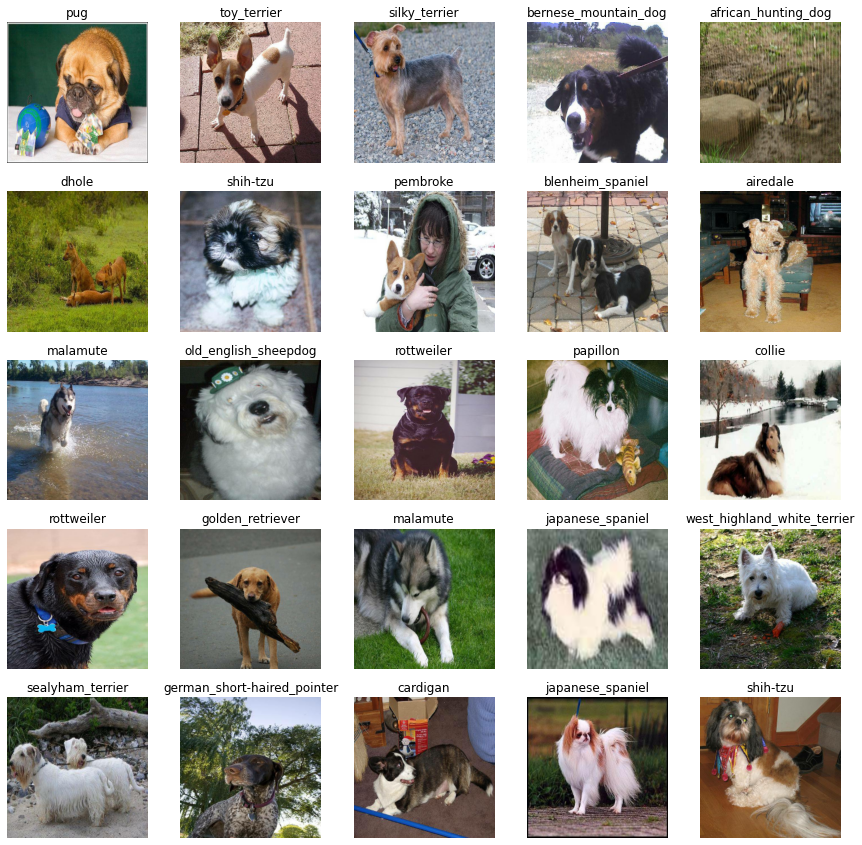

In [36]:
# now let's visualize data into a training data batch
show_25_images(train_images,train_labels)

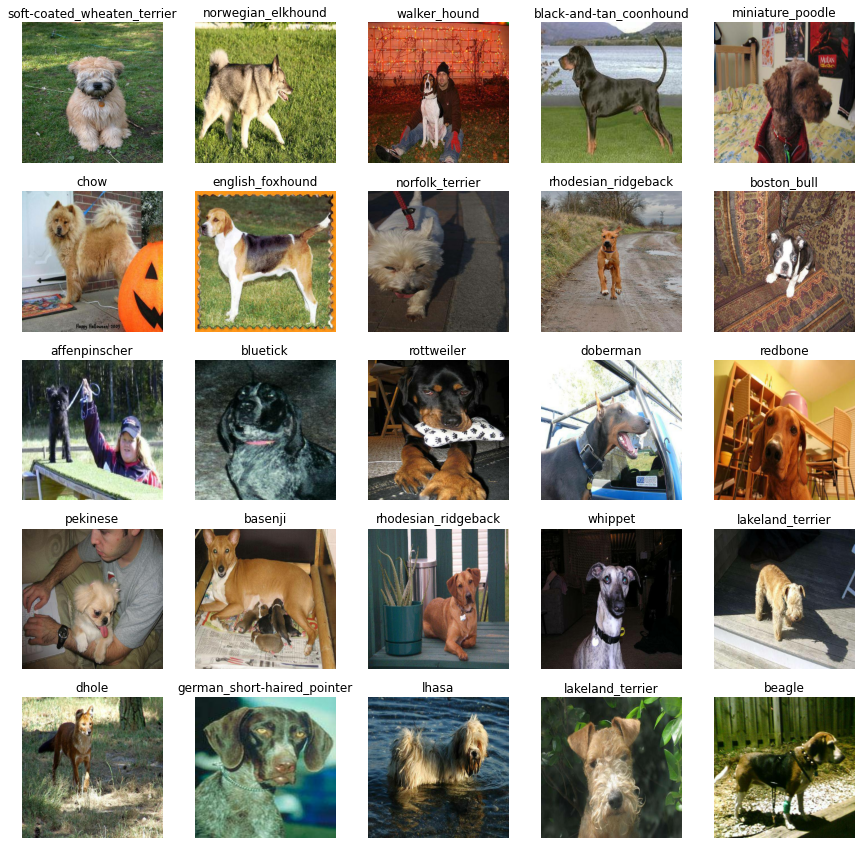

In [37]:
# let's visualize our validation data batch
valid_images,valid_labels=next(val_data.as_numpy_iterator())
show_25_images(valid_images,valid_labels)

### Creating and training a model

Now that our data is ready, let's prepare it's modelling. We'll use an existing model from TensorFlow Hub.

Tensorflow Hub is a resource where you can find pretrained machine learning models for the problem you're working on.

Using a pretrained machine learning model is often reffered as transfer learning.

We'll also use a pretrained machine learning model which we will download from the tensorflow hub. This will reduce our training time. We can find this model under the domain of image classification as we're working on image multi classification problem.

**Building a model**

Before we build a model, there are few things we need to define:
1. The input shape(images, in the form of tensors) to our model.
2. The output shape(images labels, in the form of tensors).
3. The URL of the model we will use for our problem.

In [38]:
# Setup the input shape of the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]

# Setup the output shape of the model
OUTPUT_SHAPE=len(unique_breeds)

# Setup the model URL from tensorflow hub
MODEL_URL= "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

There are many ways of building a model in the TensorFlow but one of the best ways to get started is to use the Keras API


Defining a deep learning model in Keras can be as straightforward as saying, "here are the layers of the model, the input shape and the output shape, let's go!"

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

In [42]:
# Create a function which builds keras model

def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with :",MODEL_URL)

  # setup the model layers 
  model=tf.keras.Sequential([
    hub.kerasLayer(MODEL_URL),  # Layer1 (input_layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation="softmax") #Layer2(Output layers)
    ])
  
  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])


  # Build the model
  model.build(INPUT_SHAPE)

  return model

#### Setting up the model layers

There are two ways to do this in Keras, the [functional](https://www.tensorflow.org/guide/keras/functional) and [sequential API](https://www.tensorflow.org/guide/keras/overview#build_a_simple_model). We've used the sequential.

Which one should you use?

The Keras documentation states the functional API is the way to go for defining complex models but the sequential API (a linear stack of layers) is perfectly fine for getting started, which is what we're doing.

The first layer we use is the model from TensorFlow Hub (`hub.KerasLayer(MODEL_URL)`. So our first layer is actually an entire model (many more layers). This **input layer** takes in our images and finds patterns in them based on the patterns [`mobilenet_v2_130_224`](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4) has found.

The next layer (`tf.keras.layers.Dense()`) is the **output layer** of our model. It brings all of the information discovered in the input layer together and outputs it in the shape we're after, 120 (the number of unique labels we have).

The `activation="softmax"` parameter tells the output layer, we'd like to assign a probability value to each of the 120 labels [somewhere between 0 & 1](https://en.wikipedia.org/wiki/Softmax_function). The higher the value, the more the model believes the input image should have that label. If we were working on a binary classification problem, we'd use `activation="sigmoid"`.

For more on which activation function to use, see the article [Which Loss and Activation Functions Should I Use](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)?

#### Compiling the model

This one is best explained with a story.

Let's say you're at the international hill descending championships. Where your start standing on top of a hill and your goal is to get to the bottom of the hill. The catch is you're blindfolded.

Luckily, your friend Adam is standing at the bottom of the hill shouting instructions on how to get down.

At the bottom of the hill there's a judge evaluating how you're doing. They know where you need to end up so they compare how you're doing to where you're supposed to be. Their comparison is how you get scored.

Transferring this to `model.compile()` terminology:
* `loss` - The height of the hill is the loss function, the models goal is to minimize this, getting to 0 (the bottom of the hill) means the model is learning perfectly.
* `optimizer` - Your friend Adam is the optimizer, he's the one telling you how to navigate the hill (lower the loss function) based on what you've done so far. His name is Adam because the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is a great general which performs well on most models. Other optimizers include [RMSprop](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop) and [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).
* `metrics` - This is the onlooker at the bottom of the hill rating how well your perfomance is. Or in our case, giving the accuracy of how well our model is predicting the correct image label.

#### Building the model

We use `model.build()` whenever we're using a layer from TensorFlow Hub to tell our model what input shape it can expect.

In this case, the input shape is `[None, IMG_SIZE, IMG_SIZE, 3]` or `[None, 224, 224, 3]` or `[batch_size, img_height, img_width, color_channels]`.

Batch size is left as `None` as this is inferred from the data we pass the model. In our case, it'll be 32 since that's what we've set up our data batches as.

Now we've gone through each section of the function, let's use it to create a model.

We can call `summary()` on our model to get idea of what our model looks like.

In [43]:
model=create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


AttributeError: ignored